# ERC-20 Transaction-Based Model

### Import Required Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import time
from etherscan import Etherscan
import custom_functions as cf
import numpy as np
import datetime

pd.options.display.float_format = '{:.3f}'.format

### ERC-20 Transaction Acquisition

In [2]:
#Read in Illicit Addresses
#all_illicit_addresses = pd.read_csv('all_illicit_addresses.csv', index_col=0)
#all_illicit_addresses = all_illicit_addresses['0'].tolist()

In [3]:
%%time
#Get Illicit ERC20 Transactions

#Define Block Range
#start_block = 1
#end_block = 18000000

#all_illicit_addresses = [i.lower() for i in all_illicit_addresses]
#illicit_erc20_txs_list = []
#for i in all_illicit_addresses:
#    try:
#        erc20_txs = eth.get_erc20_token_transfer_events_by_address(i, start_block, end_block, 'asc')
#    except:
#        erc20_txs = []
#    for i in erc20_txs:
#        illicit_erc20_txs_list.append(i)


erc20_illicit = pd.read_csv('all_erc20_illicit_transactions.csv', index_col=0)

CPU times: user 692 ms, sys: 76.5 ms, total: 768 ms
Wall time: 809 ms


In [4]:
#Read in Randomly Sampled Legal Addresses
#legal_accounts = pd.read_csv('all_legal_addresses.csv', index_col=0)
#legal_accounts = legal_accounts['Address'].tolist()
#len(legal_accounts)

In [5]:
%%time
#Get Legal ERC20 Transactions

#erc20_legal_txs_list = []
#for i in legal_accounts:
#    try:
#        erc20_txs = eth.get_erc20_token_transfer_events_by_address(i, start_block, end_block, 'asc')
#        for i in erc20_txs:
#            erc20_legal_txs_list.append(i)
#    except:
#        continue

erc20_legal = pd.read_csv('all_erc20_legal_transactions.csv',index_col=0)

CPU times: user 1.03 s, sys: 126 ms, total: 1.16 s
Wall time: 1.22 s


### Data Wrangling

In [6]:
#Ensure no overlap with illicit transactions 
erc20_illicit_no_overlap = pd.merge(erc20_illicit,erc20_legal, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
len(erc20_illicit_no_overlap)

erc20_legal_no_overlap = pd.merge(erc20_legal,erc20_illicit, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
len(erc20_legal_no_overlap)

282770

300000

In [7]:
#Add Flags
erc20_illicit_no_overlap['FLAG'] = 1
erc20_legal_no_overlap['FLAG'] = 0

In [8]:
illicit_txs_trimmed = erc20_illicit_no_overlap[['hash','timeStamp','FLAG', 'nonce', 'value', 'gas', 'gasPrice','transactionIndex','tokenDecimal']]
illicit_txs_trimmed
legal_txs_trimmed = erc20_legal_no_overlap[['hash','timeStamp','FLAG', 'nonce', 'value', 'gas', 'gasPrice','transactionIndex','tokenDecimal']]
legal_txs_trimmed

,hash,timeStamp,FLAG,nonce,value,gas,gasPrice,transactionIndex,tokenDecimal
0,0x9905727a12d1bcc669e10541f8f2883e10afb3123fa4...,1677158903,1,2879,0,18500000,31729040069,14,6.000
1,0x0f05aad8b87e1c77680cc35d0ef46aae5cfd778a02b2...,1677159071,1,8920,500000,6000000,33668069462,30,6.000
2,0x0f05aad8b87e1c77680cc35d0ef46aae5cfd778a02b2...,1677159071,1,8920,500000,6000000,33668069462,30,6.000
3,0x7ad56c92f245fc061d6a0c28b0b8ed15b1582c90f39b...,1677159071,1,2884,0,18500000,33668069462,31,6.000
4,0x2cb16db1a87273261b1547802cda04e8579fa8e27703...,1677159395,1,2894,0,18500000,36530909942,28,6.000
...,...,...,...,...,...,...,...,...,...
282765,0xd22f85a21face7a0a1db35278fc7eb558034348d40cd...,1677178859,1,9007,50000,6000000,60996842713,10,6.000
282766,0x3df08815fe7fedb8bbd3614ff96919f68de841ee341b...,1677349859,1,7169,0,18500000,23536695887,14,6.000
282767,0x1fc5573d26c2af1cf6f7322087a9884832f91d47e3e5...,1677165599,1,2996,0,18500000,78374073779,14,6.000
282768,0x9090a68a55f5849b13b7dbdabeada2cb12a521243b10...,1677171635,1,8979,16080,6000000,53378314475,4,6.000


,hash,timeStamp,FLAG,nonce,value,gas,gasPrice,transactionIndex,tokenDecimal
0,0x65509d1c648dce60051fde4fe9608cb50d49b6cbd7e0...,1690659935,0,1490,100000000000000000000,133039,40967840892,27,18.000
1,0xa5d634defaf38723804de271529778fa47f17770d1f0...,1646617418,0,317,92000000,120000,39732712700,123,6.000
2,0x417f10fed50223e4efff33a69f8b4df09a6511c22638...,1607662485,0,132,7137999999999997500000,620000,20200000000,60,18.000
3,0x142b69aa9e2d77a4cbb958fb7af9075c459a0161333a...,1688454779,0,154,982410000000000000,343086,13959913642,84,18.000
4,0xb4c70d7e8ef04aa682e6b59d6c6117ff6b7720536b2e...,1671223223,0,5394139,4834348320000000000,414256,17027037567,24,18.000
...,...,...,...,...,...,...,...,...,...
299995,0x5d50bd99ff76dbb2c6d496493302ad358ae2445771f7...,1653022137,0,20,39634356998425753,379675,14449517858,43,18.000
299996,0xcdc7b2771c1bb64b23b302d74848794e7e097797a56b...,1675018859,0,16733,5218840753766800405721,1000000,45122163718,6,18.000
299997,0xe3fec2bdde87a9f4447563e8bd46b91fbec0b53c428b...,1677005615,0,48391,57772563,90000,38369082113,13,6.000
299998,0xd6ecd368e7d3553e64b83e1f3a384bdd63debbad50cd...,1686941159,0,797,172055023,172216,22511685477,102,6.000


In [9]:
new_value = []
for i in illicit_txs_trimmed.index:
    new_value.append(int(illicit_txs_trimmed['value'][i]) / cf.decimal_divisor(int(illicit_txs_trimmed['tokenDecimal'][i])))

illicit_txs_trimmed['value'] = new_value

#Refine Features
illicit_txs_trimmed = illicit_txs_trimmed[['hash', 'FLAG','timeStamp', 'nonce', 'value', 'gas', 'gasPrice','transactionIndex']]

#Drop Values Higher Than Float 32
illicit_txs_trimmed = illicit_txs_trimmed.drop(illicit_txs_trimmed[illicit_txs_trimmed['value'] > cf.decimal_divisor(32)].index)

#Display Dataframe
illicit_txs_trimmed

/var/folders/2f/_dm57pgd7m7fnb0xgm506pbr0000gn/T/ipykernel_56273/2408288587.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  illicit_txs_trimmed['value'] = new_value


,hash,FLAG,timeStamp,nonce,value,gas,gasPrice,transactionIndex
0,0x9905727a12d1bcc669e10541f8f2883e10afb3123fa4...,1,1677158903,2879,0.000,18500000,31729040069,14
1,0x0f05aad8b87e1c77680cc35d0ef46aae5cfd778a02b2...,1,1677159071,8920,0.500,6000000,33668069462,30
2,0x0f05aad8b87e1c77680cc35d0ef46aae5cfd778a02b2...,1,1677159071,8920,0.500,6000000,33668069462,30
3,0x7ad56c92f245fc061d6a0c28b0b8ed15b1582c90f39b...,1,1677159071,2884,0.000,18500000,33668069462,31
4,0x2cb16db1a87273261b1547802cda04e8579fa8e27703...,1,1677159395,2894,0.000,18500000,36530909942,28
...,...,...,...,...,...,...,...,...
282765,0xd22f85a21face7a0a1db35278fc7eb558034348d40cd...,1,1677178859,9007,0.050,6000000,60996842713,10
282766,0x3df08815fe7fedb8bbd3614ff96919f68de841ee341b...,1,1677349859,7169,0.000,18500000,23536695887,14
282767,0x1fc5573d26c2af1cf6f7322087a9884832f91d47e3e5...,1,1677165599,2996,0.000,18500000,78374073779,14
282768,0x9090a68a55f5849b13b7dbdabeada2cb12a521243b10...,1,1677171635,8979,0.016,6000000,53378314475,4


In [10]:
#Clean ERC20 Legal
legal_txs_trimmed = legal_txs_trimmed.dropna()
len(legal_txs_trimmed)

new_value = []
for i in legal_txs_trimmed.index:
    new_value.append(int(legal_txs_trimmed['value'][i]) / cf.decimal_divisor(int(legal_txs_trimmed['tokenDecimal'][i])))

legal_txs_trimmed['value'] = new_value

#Refine Features
legal_txs_trimmed = legal_txs_trimmed[['hash', 'FLAG','timeStamp','nonce', 'value', 'gas', 'gasPrice','transactionIndex']]

#Drop Values Higher Than Float 32
legal_txs_trimmed = legal_txs_trimmed.drop(legal_txs_trimmed[legal_txs_trimmed['value'] > cf.decimal_divisor(32)].index)

#Display Dataframe
legal_txs_trimmed

299994

/var/folders/2f/_dm57pgd7m7fnb0xgm506pbr0000gn/T/ipykernel_56273/1386815447.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legal_txs_trimmed['value'] = new_value


,hash,FLAG,timeStamp,nonce,value,gas,gasPrice,transactionIndex
0,0x65509d1c648dce60051fde4fe9608cb50d49b6cbd7e0...,0,1690659935,1490,100.000,133039,40967840892,27
1,0xa5d634defaf38723804de271529778fa47f17770d1f0...,0,1646617418,317,92.000,120000,39732712700,123
2,0x417f10fed50223e4efff33a69f8b4df09a6511c22638...,0,1607662485,132,7138.000,620000,20200000000,60
3,0x142b69aa9e2d77a4cbb958fb7af9075c459a0161333a...,0,1688454779,154,0.982,343086,13959913642,84
4,0xb4c70d7e8ef04aa682e6b59d6c6117ff6b7720536b2e...,0,1671223223,5394139,4.834,414256,17027037567,24
...,...,...,...,...,...,...,...,...
299995,0x5d50bd99ff76dbb2c6d496493302ad358ae2445771f7...,0,1653022137,20,0.040,379675,14449517858,43
299996,0xcdc7b2771c1bb64b23b302d74848794e7e097797a56b...,0,1675018859,16733,5218.841,1000000,45122163718,6
299997,0xe3fec2bdde87a9f4447563e8bd46b91fbec0b53c428b...,0,1677005615,48391,57.773,90000,38369082113,13
299998,0xd6ecd368e7d3553e64b83e1f3a384bdd63debbad50cd...,0,1686941159,797,172.055,172216,22511685477,102


In [11]:
#Combine Datasets Together 
dfs = [illicit_txs_trimmed,legal_txs_trimmed]
all_erc20_txs = pd.concat(dfs)
all_erc20_txs

,hash,FLAG,timeStamp,nonce,value,gas,gasPrice,transactionIndex
0,0x9905727a12d1bcc669e10541f8f2883e10afb3123fa4...,1,1677158903,2879,0.000,18500000,31729040069,14
1,0x0f05aad8b87e1c77680cc35d0ef46aae5cfd778a02b2...,1,1677159071,8920,0.500,6000000,33668069462,30
2,0x0f05aad8b87e1c77680cc35d0ef46aae5cfd778a02b2...,1,1677159071,8920,0.500,6000000,33668069462,30
3,0x7ad56c92f245fc061d6a0c28b0b8ed15b1582c90f39b...,1,1677159071,2884,0.000,18500000,33668069462,31
4,0x2cb16db1a87273261b1547802cda04e8579fa8e27703...,1,1677159395,2894,0.000,18500000,36530909942,28
...,...,...,...,...,...,...,...,...
299995,0x5d50bd99ff76dbb2c6d496493302ad358ae2445771f7...,0,1653022137,20,0.040,379675,14449517858,43
299996,0xcdc7b2771c1bb64b23b302d74848794e7e097797a56b...,0,1675018859,16733,5218.841,1000000,45122163718,6
299997,0xe3fec2bdde87a9f4447563e8bd46b91fbec0b53c428b...,0,1677005615,48391,57.773,90000,38369082113,13
299998,0xd6ecd368e7d3553e64b83e1f3a384bdd63debbad50cd...,0,1686941159,797,172.055,172216,22511685477,102


### Descriptive Statistics

In [12]:
cf.descriptive_statistics_transactions(legal_txs_trimmed, 'Legal', illicit_txs_trimmed, 'Illicit', 'mean')

,Features,Legal,Illicit
0,FLAG,0.000,1.000
1,timeStamp,1661371184.944,1608435257.094
2,nonce,83404.546,29571.414
3,value,1012125507358653088016629760.000,710901809414590743707648.000
4,gas,998839.033,2631768.413
5,gasPrice,48842400273.857,55049811000.001
6,transactionIndex,83.018,78.714


### Train ERC-20 Model

In [13]:
#Train Inital ERC20 Model
inital_column_drop = ['hash', 'FLAG','timeStamp']

X=all_erc20_txs.drop(columns=inital_column_drop)
y=all_erc20_txs['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

In [14]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Test Data
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))

#Training Data
rfc_pred_train = rfc.predict(X_train)
print(classification_report(y_train, rfc_pred_train))

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     89832
           1       0.95      0.93      0.94     84988

    accuracy                           0.94    174820
   macro avg       0.94      0.94      0.94    174820
weighted avg       0.94      0.94      0.94    174820

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    210153
           1       1.00      1.00      1.00    197759

    accuracy                           1.00    407912
   macro avg       1.00      1.00      1.00    407912
weighted avg       1.00      1.00      1.00    407912



array([0.20779185, 0.17911872, 0.38235715, 0.16211632, 0.06861595])

Index(['nonce', 'value', 'gas', 'gasPrice', 'transactionIndex'], dtype='object')

<Figure size 1000x800 with 0 Axes>

<BarContainer object of 5 artists>

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 [Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.1, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35'),
  Text(0.4, 0, '0.40'),
  Text(0.45, 0, '0.45')])

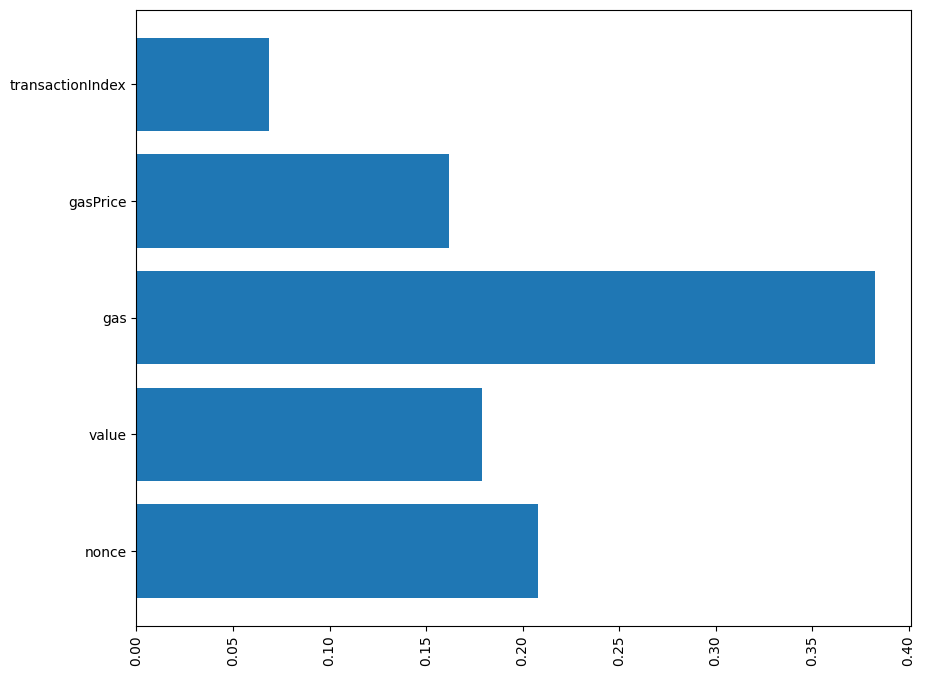

In [15]:
rfc.feature_importances_
X.columns

from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
plt.barh(X.columns, rfc.feature_importances_)
plt.xticks(rotation=90)

### Split Train & Test by Timestamp

In [16]:
#Split Each Dataset By Timestamp
datetime.datetime.fromtimestamp(illicit_txs_trimmed.timeStamp.min())
datetime.datetime.fromtimestamp(illicit_txs_trimmed.timeStamp.max())

datetime.datetime.fromtimestamp(legal_txs_trimmed.timeStamp.min())
datetime.datetime.fromtimestamp(legal_txs_trimmed.timeStamp.max())

illicit_train = illicit_txs_trimmed[illicit_txs_trimmed.timeStamp < np.percentile(illicit_txs_trimmed.timeStamp, 70)]
len(illicit_train)
illicit_test = illicit_txs_trimmed[illicit_txs_trimmed.timeStamp > np.percentile(illicit_txs_trimmed.timeStamp, 70)]
len(illicit_test)

legal_train = legal_txs_trimmed[legal_txs_trimmed.timeStamp < np.percentile(legal_txs_trimmed.timeStamp, 70)]
len(legal_train)
legal_test = legal_txs_trimmed[legal_txs_trimmed.timeStamp > np.percentile(legal_txs_trimmed.timeStamp, 70)]
len(legal_test)

train_dfs = [illicit_train,legal_train]
all_train = pd.concat(train_dfs)

test_dfs = [illicit_test, legal_test]
all_test = pd.concat(test_dfs)

datetime.datetime(2017, 3, 27, 2, 54, 17)

datetime.datetime(2023, 8, 26, 4, 20, 47)

datetime.datetime(2016, 5, 28, 2, 6, 59)

datetime.datetime(2023, 8, 26, 9, 21, 35)

197900

84797

209989

89996

### Train New Model Split on Older Transactions

In [17]:
#ERC20 Model Divided By Timestamp
inital_column_drop = ['hash', 'FLAG','timeStamp']

X_train = all_train.drop(columns=inital_column_drop)
y_train = all_train['FLAG']
X_test = all_test.drop(columns=inital_column_drop)
y_test = all_test['FLAG']

In [18]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Test Data
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))

#Training Data
rfc_pred_train = rfc.predict(X_train)
print(classification_report(y_train, rfc_pred_train))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rfc_pred)


RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.56      0.97      0.71     89996
           1       0.85      0.20      0.32     84797

    accuracy                           0.60    174793
   macro avg       0.71      0.58      0.52    174793
weighted avg       0.70      0.60      0.52    174793

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209989
           1       1.00      1.00      1.00    197900

    accuracy                           1.00    407889
   macro avg       1.00      1.00      1.00    407889
weighted avg       1.00      1.00      1.00    407889



array([[87104,  2892],
       [67873, 16924]])

array([0.27587878, 0.15289692, 0.33224703, 0.16836453, 0.07061274])

Index(['nonce', 'value', 'gas', 'gasPrice', 'transactionIndex'], dtype='object')

<Figure size 1000x800 with 0 Axes>

<BarContainer object of 5 artists>

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.1, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35')])

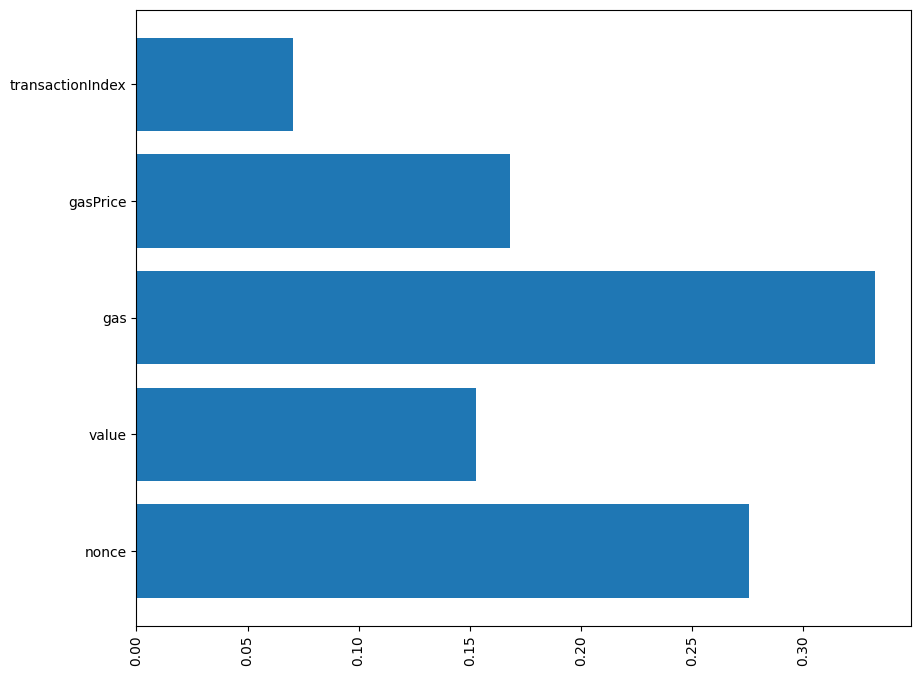

In [19]:
rfc.feature_importances_
X_train.columns

from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
plt.barh(X_train.columns, rfc.feature_importances_)
plt.xticks(rotation=90)